# Earth Engine as a tile server

In [1]:
import ee

ee.Initialize()

## Sentinel 2  
### Sentinel-2 MSI: MultiSpectral Instrument, Level-1C ([gee](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2))
**Dataset Availability**: 2015-06-23T00:00:00 - Present

In [150]:
def CloudMaskS2(image):
    """
    European Space Agency (ESA) clouds from 'QA60', i.e. Quality Assessment band at 60m
    parsed by Nick Clinton
    """
    qa = image.select('QA60')

    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = 1 << 10
    cirrusBitMask = int(1 << 11)

    # Both flags set to zero indicates clear conditions.
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(\
            qa.bitwiseAnd(cirrusBitMask).eq(0))

    return image.updateMask(mask).divide(10000)

def CloudFreeCompositeS2(Collection_id, startDate, stopDate):
    ## Define your collection
    collection = ee.ImageCollection(Collection_id)

    ## Filter 
    collection = collection.filterDate(startDate,stopDate)\
            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))\
            .map(CloudMaskS2)
    
    ## Composite
    composite = collection.median()
    
    return composite

In [151]:
# GEE Image Collection ID
Collection_id = 'COPERNICUS/S2'
# Start and stop of time series
#'2018-01-01', '2018-06-30'
startDate = ee.Date('2018-01-01')
stopDate  = ee.Date('2018-12-31')
# Visualization parameters
vis = {'min':0,'max':0.3}
# Cloud Free Composite
composite = CloudFreeCompositeS2(Collection_id, startDate, stopDate)

**RGB Image**

In [152]:
# RGB Bands
bands_rgb = ['B4','B3','B2']

## Select bands
image_rgb = composite.select(bands_rgb)

**Image with `NIR`, `NDVI`, and `NDWI` bands**

In [153]:
# NIR band
band_nir = ['B8']

# Bands to compute the 'NDVI' and 'NDWI'
normDiff_bands = [['B8','B4'], ['B8','B3']]

# Normalized Difference band names
normDiff_band_names = ['ndvi', 'ndwi']

## Select bands
for nB, normDiff_band in enumerate(normDiff_bands):
    image_nd = composite.normalizedDifference(normDiff_band).rename(normDiff_band_names[nB])
    ## Concatenate images into one multi-band image
    if nB == 0:
        image_nir = ee.Image.cat([composite.select(band_nir), image_nd])
    else:
        image_nir = ee.Image.cat([image_nir, image_nd])

### Display the results on a map

In [106]:
import folium

In [107]:
def tile_url(image, viz_params=None):
    """Create a target url for tiles for an image.
    """
    if viz_params:
        d = image.getMapId(viz_params)
    else:
        d = image.getMapId()
    base_url = 'https://earthengine.googleapis.com'
    url = (base_url + '/map/' + d['mapid'] + '/{z}/{x}/{y}?token=' + d['token'])
    return url

In [169]:
def tile_url_zxy(image, zxy, viz_params=None):
    """Create a target url for tiles for an image.
    """
    if viz_params:
        d = image.getMapId(viz_params)
    else:
        d = image.getMapId()
    base_url = 'https://earthengine.googleapis.com'
    url = (base_url + '/map/' + d['mapid'] + "/{}/{}/{}?token=".format(zxy[0],zxy[1],zxy[2]) + d['token'])
    return url

**RGB Image**

In [271]:
tile_rgb = tile_url_zxy(image_rgb, [13,4022,3010], {'min':0,'max':0.3})
tile_rgb

'https://earthengine.googleapis.com/map/1af012db64f85891a2339fc2a910c2cd/13/4022/3010?token=6d29cbb8fe03c5a8bb5f9ff0b49a5b24'

In [334]:
from PIL import Image
import requests
from io import BytesIO

response = requests.get(tile_rgb)
img_rgb = Image.open(BytesIO(response.content))
img_rgb

CPU times: user 24.6 ms, sys: 3.38 ms, total: 28 ms
Wall time: 951 ms


(256, 256, 3)


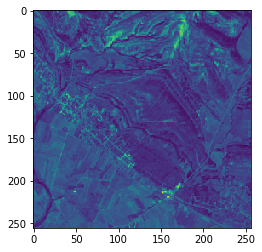

In [191]:
import numpy as np
import matplotlib.pyplot as plt
arr_rgb = np.array(img_rgb)
print(a.shape)
plt.imshow(arr_rgb[:,:,1])

In [177]:
tiles_rgb = tile_url(image_rgb, {'min':0,'max':0.3})
map = folium.Map(location=[42.9857, -3.2353], zoom_start=13, tiles='Mapbox Bright' )
map.add_tile_layer(tiles_rgb, max_zoom=19, min_zoom=1, attr="Live EE tiles")
map

**Image with `NIR`, `NDVI`, and `NDWI` bands**

In [199]:
tile_nir = tile_url_zxy(image_nir, [13,4022,3010], {'min':0,'max':0.75})
tile_nir

'https://earthengine.googleapis.com/map/1f1acc799eec2387182f86ad67225392/13/4022/3010?token=86157d87a69b8f348d46c66822bfea53'

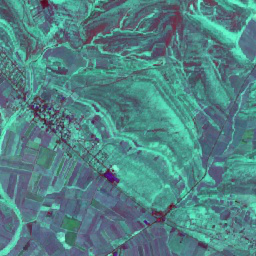

In [200]:
response = requests.get(tile_nir)
img_nir = Image.open(BytesIO(response.content))
img_nir

(256, 256, 3)


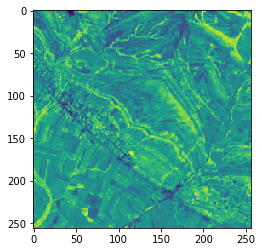

In [201]:
arr_nir = np.array(img_nir)
print(arr_nir.shape)
plt.imshow(arr_nir[:,:,2])

In [378]:
tiles_nir = tile_url(image_nir, {'min':0,'max':0.75})
map = folium.Map(location=[42.9857, -3.2353], zoom_start=13, tiles='Mapbox Bright' )
map.add_tile_layer(tiles_nir, max_zoom=19, min_zoom=1, attr="Live EE tiles")
map

### Create input array

In [342]:
def preprocess(tile_urls):
    for n, url in enumerate(tile_urls):
        # Get an image from url
        response = requests.get(url)
        img = np.array(Image.open(BytesIO(response.content)))

        if n == 0:
            arr = img
        
        else:
            arr = np.dstack((arr,img))
            
    # Normalize values
    arr = arr/255
    
    # Reshape
    shape = list(arr.shape)
    shape.insert(0,1)
    arr = arr.reshape(shape)
    
    return arr

In [343]:
tile_urls = [tile_rgb, tile_nir]

In [344]:
image = preprocess(tile_urls)

In [345]:
image.shape

(1, 256, 256, 6)

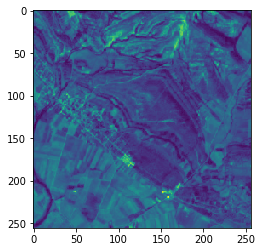

In [347]:
plt.imshow(image[0,:,:,0])

In [384]:
image[0,:,:,5].max()

0.8705882352941177

In [350]:
tile_nir

'https://earthengine.googleapis.com/map/1f1acc799eec2387182f86ad67225392/13/4022/3010?token=86157d87a69b8f348d46c66822bfea53'

**Prediction**

To use SegNet from the command line type:

```python
python predict_tiles.py -i https://earthengine.googleapis.com/map/1af012db64f85891a2339fc2a910c2cd/13/4022/3010?token=6d29cbb8fe03c5a8bb5f9ff0b49a5b24 https://earthengine.googleapis.com/map/1f1acc799eec2387182f86ad67225392/13/4022/3010?token=86157d87a69b8f348d46c66822bfea53 -o output/output_tile.hdf5 -c 4 -m segnet
```

The parameters are:

```
-i = Samples/file 
    Path of the input file.
-o = Predictions/file
    Path of the output file.
-c = 4
    Number of classes.
```

**Read output**

In [351]:
import h5py

In [358]:
f = h5py.File("../output/output_tile.hdf5", 'r')
output = f.get("output")[:]
f.close()

In [359]:
def display_channels(data, nChannels, titles = False):
    if nChannels == 1:
        plt.figure(figsize=(5,5))
        plt.imshow(data[:,:,0])
        if titles:
            plt.title(titles[0])
    else:
        fig, axs = plt.subplots(nrows=1, ncols=nChannels, figsize=(5*nChannels,5))
        for i in range(nChannels):
            ax = axs[i]
            ax.imshow(data[:,:,i])
            if titles:
                ax.set_title(titles[i])

In [360]:
output.shape

(1, 256, 256, 4)

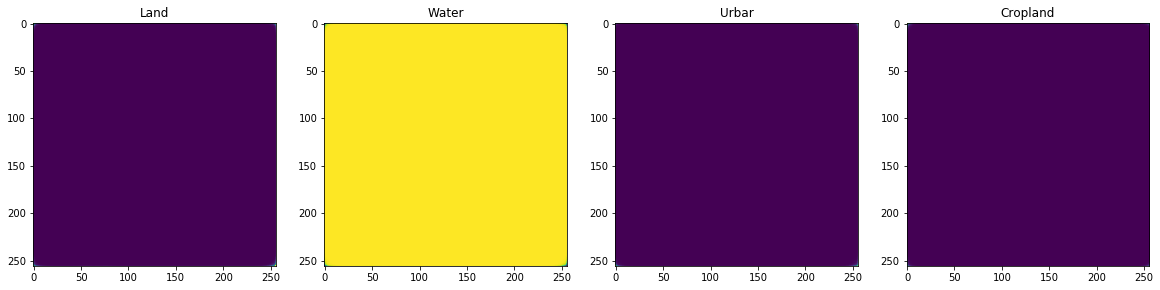

In [361]:
display_channels(output[0,:,:,:], output.shape[3], titles=['Land', 'Water', 'Urbar', 'Cropland'])